## Lista 3 - Aprendizagem de máquina probabilístico
- Aluno: Lucas Rodrigues Aragão - Graduação 538390

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal as mvn
from sklearn.cluster import KMeans

## Solução MAP para modelos de mistura gaussiana usando Expectation Maximization

1. Escolher os hiperparâmetros $K, \alpha_k, m_0, \kappa_0, \nu_0, S_0 ,\pi^{(0)}_k, \mu_k^{(0)}, \Sigma^{(0)}_{k}, \space \forall_k$

Valores comuns: $S_0 = \frac{1}{K^{2/D}} S_{\bar{x}}$, $\nu_0 = D+2$, $m_0 = \bar{x}$ e $\kappa_0 = 0.01$. Em que $\bar{x}$ é a média amostral e $S_{\bar{x}}$ é a covariância amostral.

### Expectation

$$r_{ik} \triangleq p(z_i = k| x_i, \theta^{(t-1)}) = \frac{\pi_k^{(t-1)} \mathcal{N}(x_i| \mu_k^{(t-1)}, \Sigma_{k}^{(t-1)})}{\sum^{K}_{k'} \pi^{(t-1)}_{k'} \mathcal{N}(x_i| \mu_{k'}^{(t-1)}, \Sigma_{k'}^{(t-1)})} $$

### Maximization

$$\pi_k^{(t)} = \frac{\alpha_k - 1 + \Sigma_i r_{ik}}{N-K + \sum_k \alpha_k}$$

$$\bar{x_k} \triangleq \frac{\Sigma_i r_{ik}x_i}{\Sigma_i r_{ik}}$$

$$\mu_k^{(t)} = \frac{\kappa_0m_0 + \bar{x}_k \Sigma_i r_{ik}}{\kappa_0 + \Sigma_i r_{ik}}$$

$$\Sigma_k^{(t)} = \frac{S_0 + \sum_i r_{ik} (x_i - \bar{x}_k) (x_i - \bar{x}_k)^T + \frac{\kappa_0 \sum_i r_{ik}}{\kappa_0 + \sum_i r_{ik}} (\bar{x}_k - m_0) (\bar{x}_k -m_0)^T}{\nu_0 + D + 2 + \sum_i r_{ik}}$$


In [2]:
class EmGMM():
    def __init__(self, K, alpha, m0, k0, nu0, s0, pi0, mu0k, sigma0):
        self.K = K
        self.alpha = alpha
        self.m0 = m0 
        self.kappa = k0
        self.nu = nu0
        self.S0 = s0
        self.pi = pi0 
        self.mu = mu0k
        self.sigma = sigma0
        self.log_likelihood_history = []        


    def expectation(self, xi, index, epoch = None):
        K = self.K
        responsibility_sum = np.sum([
            self.pi[k] * mvn.pdf(xi, mean=self.mu[k], cov=self.sigma[k])
            for k in range(K)
        ])

        for k in range(K):
            num = self.pi[k] * mvn.pdf(xi, mean=self.mu[k], cov=self.sigma[k])
            self.responsabilities[index, k] = num / responsibility_sum

        #if index == 0 and epoch is not None:
        #    print(f"{epoch}: {self.responsabilities[index]}")


    def maximizationMAP(self, X, N):
        K = self.K
        D = X.shape[1]

        for k in range(K):
            r_k = self.responsabilities[:, k]
            r_sum = np.sum(r_k)

            x_bar_k = np.sum(r_k[:, None] * X, axis=0) / r_sum

            self.pi[k] = (self.alpha[k] - 1 + r_sum)/(N - K + np.sum(self.alpha))
            self.mu[k] = (self.kappa * self.m0 + x_bar_k * r_sum)/(self.kappa + r_sum)

            diff_i = X - x_bar_k
            diff_k = x_bar_k - self.m0

            term2 = diff_i.T @ (r_k[:, None] * diff_i)  
            term3 = ((self.kappa * r_sum) / (self.kappa + r_sum)) * diff_k @ diff_k.T
            
            self.sigma[k] = (self.S0 + term2 + term3) / (self.nu + D + 2 + r_sum) + np.eye(D) *10e-6
        
    def log_likelihood(self, X):
        X = np.atleast_2d(X)
        N, D = X.shape
        K = self.K
        pdfs = np.zeros((N, K))
        for k in range(K):
            pdfs[:, k] = self.pi[k] * mvn.pdf(X, mean=self.mu[k], cov=self.sigma[k], allow_singular=True)
        row_sums = np.sum(pdfs, axis=1)
        row_sums = np.clip(row_sums, 1e-300, None)
        return np.sum(np.log(row_sums))



    def train(self, X ,epochs, responsabilities_init=None):
        N = X.shape[0] 
        
        if responsabilities_init is not None:
            self.responsabilities = responsabilities_init.copy()
        else:
            self.responsabilities = np.random.rand(N, self.K)
            self.responsabilities /= self.responsabilities.sum(axis=1, keepdims=True)
        
        ll = self.log_likelihood(X)
        self.log_likelihood_history.append(ll)  

        for epoch in range(epochs):
            for index, xi in enumerate(X):
                #if index == 0 and epoch == 0:
                    #print(f"initial: {self.responsabilities[index]}")
                self.expectation(xi, index, epoch)
            self.maximizationMAP(X, N)
            ll = self.log_likelihood(X)
            self.log_likelihood_history.append(ll)

## Métricas de avaliação

Sejam M o número de parâmetros do modelo , N o total de obsevações e K o número de centroídes do modelo;

M é dado por: $M = K-1 + K \times D + K \times D \times (D+1)/2$

### Bayesian Information Criterion

$$BIC(D,K) \triangleq \log p(D|\hat{\theta}) - \frac{1}{2} M \log N $$

### Akaike Information Criterion

$$AIC(D,K) \triangleq \log p(D|\hat{\theta}) - M$$

In [3]:
def evaluate(self, X, bic = True, aic = True, ll = True):
    # M = k-1 + k * D + K * D * (D+1)/2
    K = self.K
    D = X.shape[1]
    M = (K - 1) + K * D + K * D * (D + 1) / 2

    if bic == True:
        bic = self.log_likelihood(X) - (1/2  * M * np.log(X.shape[0]))
    if aic == True:
        aic = self.log_likelihood(X) - M
    if ll == True:
        ll = self.log_likelihood(X)
    return bic, aic, ll

EmGMM.evaluate = evaluate

## Questão 1

In [4]:
data = pd.read_csv("clustering_data.csv", header= None)
data = data.astype(float)
data_train, data_val = train_test_split(data, test_size= 0.2)

In [5]:
data

,0,1
0,-9.324269,-8.524550
1,-4.802893,4.568391
2,-9.151913,-7.235600
3,6.631406,6.885714
4,5.800550,7.154082
...,...,...
95,2.681695,0.991633
96,4.537232,9.209128
97,6.648542,4.320721
98,11.841266,-4.693716


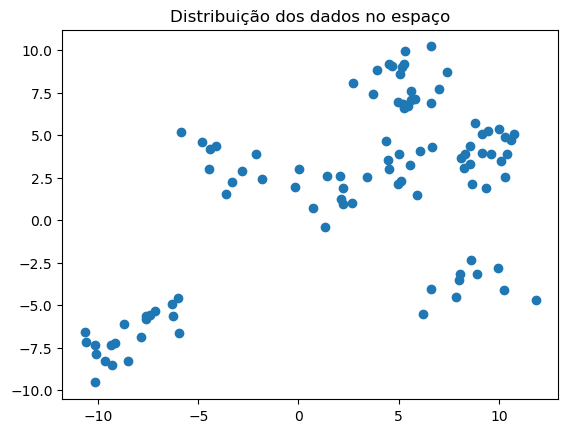

In [6]:
plt.scatter(data[0], data[1])
plt.title("Distribuição dos dados no espaço")
plt.show()

### Testar para os 15 Ks

In [7]:
bics = []
aics = []
lls_train = []
lls_val = []

N, D = data_train.shape
m0 = data_train.mean(axis=0)
Sx = np.cov(data_train, rowvar=False)

k0 = 0.1
nu0 = D + 2

for k in range(1, 16):
    S0 = Sx / (k ** (2.0 / D))
    alpha = np.ones(k)            
    pi0 = np.ones(k) / k
    
    km = KMeans(n_clusters=k, random_state=0).fit(data_train)
    mu0k = km.cluster_centers_
    
    responsabilities_init = np.zeros((N, k))
    responsabilities_init[np.arange(N), km.labels_] = 1.0

    X_np = np.asarray(data_train)  # converte se necessário

    responsabilities_init = np.zeros((data_train.shape[0], k))
    responsabilities_init[np.arange(data_train.shape[0]), km.labels_] = 1.0

    # adicionar pequeno ruído
    responsabilities_init += 1e-2 * np.random.rand(N, k)

    # normalizar para cada amostra somar 1
    responsabilities_init /= responsabilities_init.sum(axis=1, keepdims=True)

    sigma0 = np.array([Sx + np.eye(D)*1e-6 for _ in range(k)])

    model = EmGMM(K=k, alpha=alpha, m0=m0, k0=k0, nu0=nu0, s0=S0,
                  pi0=pi0, mu0k=mu0k, sigma0=sigma0)
    
    model.train(X=data_train, epochs=30, responsabilities_init= responsabilities_init)
    bic, aic, ll_train =  model.evaluate(data_train)
    bics.append(bic)
    aics.append(aic)
    lls_train.append(ll_train)
    
    _, _, ll_val = model.evaluate(data_val, bic= False, aic= False)
    lls_val.append(ll_val)
    print(f"K = {k}, BIC = {bic}, AIC = {aic}, LOGLL-TRAIN = {ll_train}, LOGLL-VAL = {ll_val}")

K = 1, BIC = -504.0150668538744, AIC = -498.06000026718965, LOGLL-TRAIN = -493.06000026718965, LOGLL-VAL = -125.32786406368935
K = 2, BIC = -487.1383625580135, AIC = -474.03721606730716, LOGLL-TRAIN = -463.03721606730716, LOGLL-VAL = -115.31585083294672
K = 3, BIC = -489.16608413227135, AIC = -468.91885773754336, LOGLL-TRAIN = -451.91885773754336, LOGLL-VAL = -112.84691944964197
K = 4, BIC = -481.08996456714004, AIC = -453.6966582683904, LOGLL-TRAIN = -430.6966582683904, LOGLL-VAL = -105.53191310340085
K = 5, BIC = -480.7142722483292, AIC = -446.17488604555797, LOGLL-TRAIN = -417.17488604555797, LOGLL-VAL = -104.8567306905062
K = 6, BIC = -483.09258202149476, AIC = -441.4071159147018, LOGLL-TRAIN = -406.4071159147018, LOGLL-VAL = -103.39140478098933
K = 7, BIC = -499.75682929338376, AIC = -450.9252832825692, LOGLL-TRAIN = -409.9252832825692, LOGLL-VAL = -104.22594735049516
K = 8, BIC = -512.9551318409242, AIC = -456.97750592608804, LOGLL-TRAIN = -409.97750592608804, LOGLL-VAL = -103.88

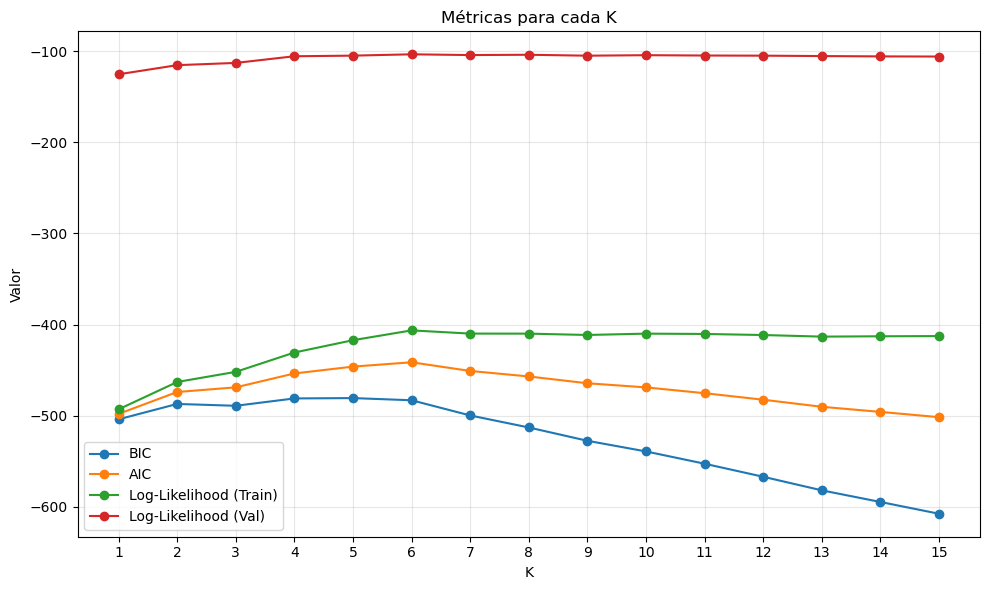

In [8]:
Ks = np.arange(1, 16)

plt.figure(figsize=(10,6))

plt.plot(Ks, bics, marker='o', label='BIC', color='tab:blue')
plt.plot(Ks, aics, marker='o', label='AIC', color='tab:orange')
plt.plot(Ks, lls_train, marker='o', label='Log-Likelihood (Train)', color='tab:green')
plt.plot(Ks, lls_val, marker='o', label='Log-Likelihood (Val)', color='tab:red')

plt.title("Métricas para cada K")
plt.xlabel("K")
plt.xticks(ticks=[i for i in range (1,16)])
plt.ylabel("Valor")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Gerar visualização para o melhor K de cada métrica

In [10]:
def treinao(X, k):
    N,D = X.shape
    m0 = X.mean(axis=0)
    Sx = np.cov(X, rowvar=False)
    k0 = 0.01
    nu0 = D + 2
    S0 = Sx / (k ** (2.0 / D))
    alpha = np.ones(k)            
    pi0 = np.ones(k) / k          

    km = KMeans(n_clusters=k, random_state=0).fit(X)
    mu0k = km.cluster_centers_

    responsabilities_init = np.zeros((X.shape[0], k))
    responsabilities_init[np.arange(X.shape[0]), km.labels_] = 1.0

    # adicionar pequeno ruído
    responsabilities_init += 1e-2 * np.random.rand(N, k)

    # normalizar para cada amostra somar 1
    responsabilities_init /= responsabilities_init.sum(axis=1, keepdims=True)

    sigma0 = np.array([Sx + np.eye(D)*1e-6 for _ in range(k)])

    model = EmGMM(K=k, alpha=alpha, m0=m0, k0=k0, nu0=nu0, s0=S0,
                    pi0=pi0, mu0k=mu0k, sigma0=sigma0)

    model.train(X=X, epochs=30, responsabilities_init= responsabilities_init)
    return model

In [11]:
def plot_clusters(X, responsibilities, mu):
    labels = np.argmax(responsibilities, axis=1)
    K = responsibilities.shape[1]

    plt.figure(figsize=(6,4))
    for k in range(K):
        mask = labels == k
        plt.scatter(X.iloc[mask, 0], X.iloc[mask, 1], s=30, label=f'Cluster {k}')
        plt.scatter(mu[k][0], mu[k][1], marker='X', c='black', s=50)
    plt.title("Clusters finais")
    #plt.legend(loc = 'upper left')
    plt.show()

In [12]:
def plot_clusters_density(X, responsibilities, mu, sigma):
    labels = np.argmax(responsibilities, axis=1)
    K = responsibilities.shape[1]

    # Limites da grade
    x = np.linspace(X.iloc[:, 0].min() - 2, X.iloc[:, 0].max() + 2, 300)
    y = np.linspace(X.iloc[:, 1].min() - 2, X.iloc[:, 1].max() + 2, 300)
    Xgrid, Ygrid = np.meshgrid(x, y)
    pos = np.dstack((Xgrid, Ygrid))

    # Densidade total (soma ponderada das gaussianas)
    Z = np.zeros(Xgrid.shape)
    for k in range(K):
        rv = mvn(mean=mu[k], cov=sigma[k])
        Z += rv.pdf(pos)

    plt.figure(figsize=(8,6))
    plt.contourf(Xgrid, Ygrid, Z, levels=100, cmap='viridis')

    # Pontos coloridos por cluster
    for k in range(K):
        mask = labels == k
        plt.scatter(X.iloc[mask, 0], X.iloc[mask, 1], s=20, label=f'Cluster {k}', alpha=0.8)
        plt.scatter(mu[k][0], mu[k][1], marker='X', c='white', edgecolors='black', s=80)

    plt.title("GMM com regiões de densidade")
    plt.legend()
    plt.show()

#### BIC: K = 5

In [25]:
modelbic= treinao(data_train, 5)

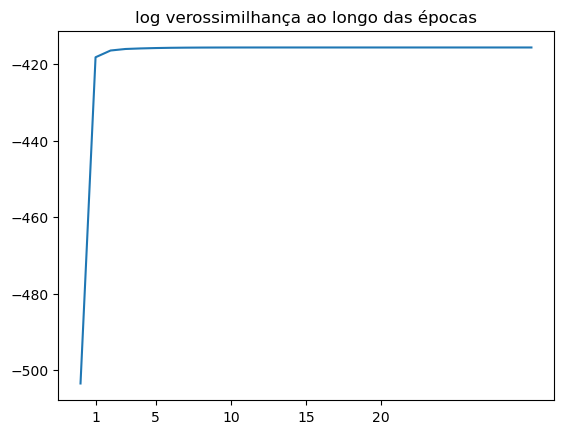

In [29]:
plt.plot(modelbic.log_likelihood_history)
plt.title("log verossimilhança ao longo das épocas")
plt.xticks([1,5,10,15,20])
plt.show()

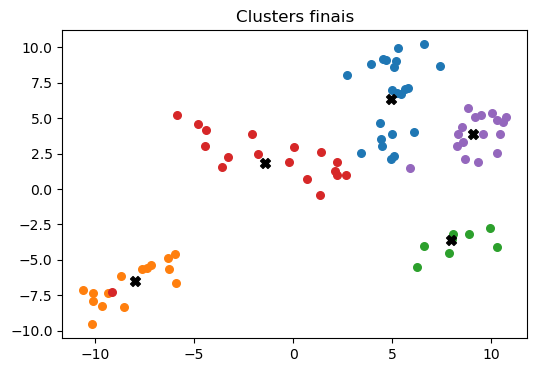

In [27]:
plot_clusters(X=data_train, responsibilities= modelbic.responsabilities, mu= modelbic.mu)

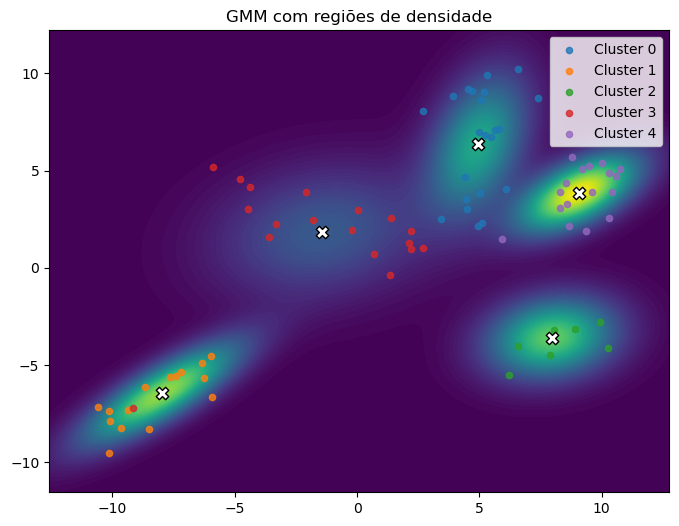

In [32]:
plot_clusters_density(X= data_train, responsibilities= modelbic.responsabilities, mu= modelbic.mu, sigma= modelbic.sigma)

#### AIC: K = 6

In [17]:
modelaic = treinao(data_train, k = 6)
modelaic.mu

array([[ 5.10707524,  8.12173005],
       [-7.99401955, -6.48100857],
       [ 7.97128158, -3.63444814],
       [-2.76300881,  3.25577302],
       [ 9.1004834 ,  4.01327968],
       [ 2.23882648,  1.5313376 ]])

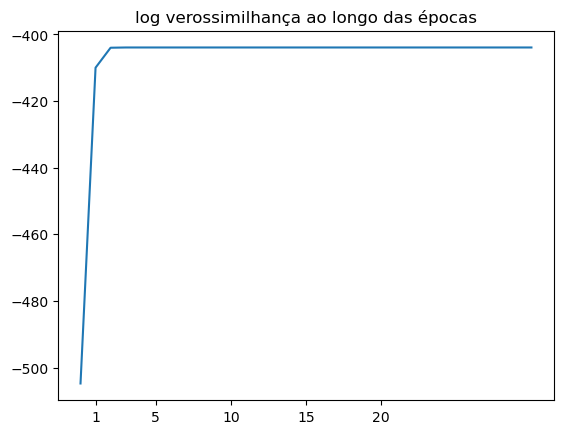

In [30]:
plt.plot(modelaic.log_likelihood_history)
plt.title("log verossimilhança ao longo das épocas")
plt.xticks([1,5,10,15,20])
plt.show()

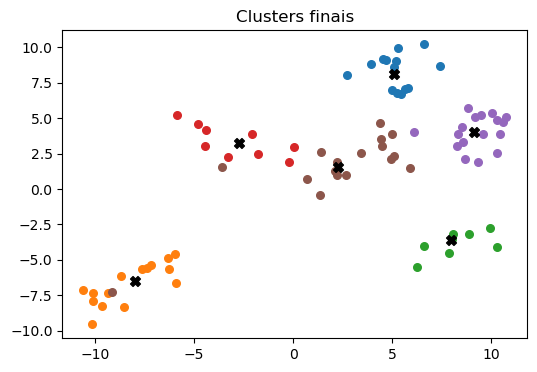

In [19]:
plot_clusters(X=data_train, responsibilities= modelaic.responsabilities, mu= modelaic.mu)

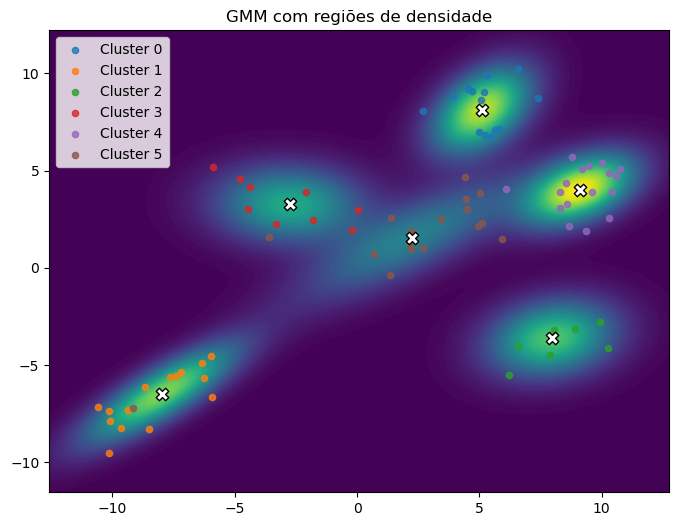

In [20]:
plot_clusters_density(X=data_train, responsibilities= modelaic.responsabilities, mu= modelaic.mu, sigma = modelaic.sigma)

#### Log verossimilhança validação: K = 6

In [21]:
modelLL = treinao(data_train, 6)
modelLL.mu

array([[ 5.09773114,  8.12063383],
       [-8.00022727, -6.49392327],
       [ 7.969566  , -3.57443301],
       [-2.77578484,  3.26320942],
       [ 9.07868579,  3.99297873],
       [ 2.22795174,  1.5420906 ]])

[-504.7641289689859, -410.59925416993366, -404.76701350239944, -404.6793548423956, -404.67795794218995, -404.6779884222787, -404.6779875582117, -404.67798757985474, -404.6779875792472, -404.67798757926244, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262, -404.677987579262]


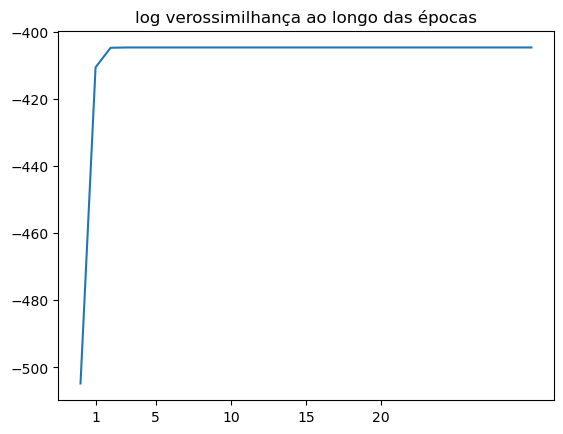

In [22]:
print(modelLL.log_likelihood_history)
plt.plot(modelLL.log_likelihood_history)
plt.title("log verossimilhança ao longo das épocas")
plt.xticks([1,5,10,15,20])
plt.show()

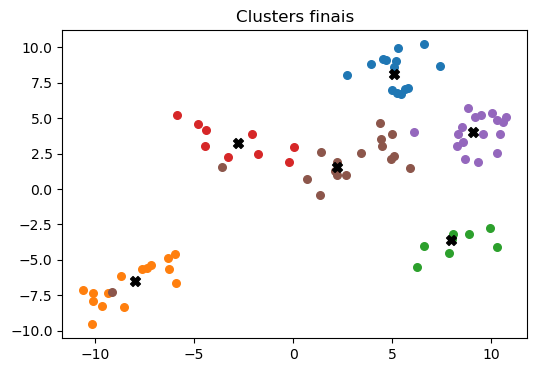

In [23]:
plot_clusters(X=data_train, responsibilities= modelLL.responsabilities, mu= modelLL.mu)

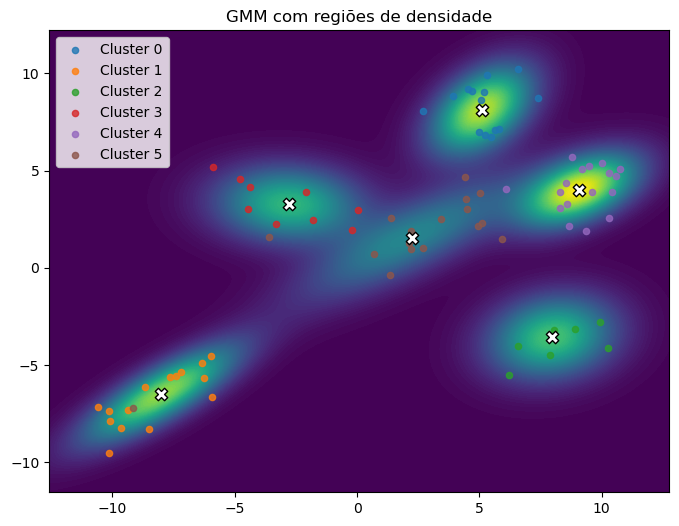

In [31]:
plot_clusters_density(X=data_train, responsibilities= modelLL.responsabilities, mu= modelLL.mu, sigma = modelLL.sigma)